In [1]:
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# !pip install smartboiler==0.0.2.10.2.9.9



Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py


/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/forecast.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/__init__.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/data_handler.py
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
def get_data_for_training_model_zuka():
    dataHandler = DataHandler(
    influx_id="localhost",
    db_name="smart_home_zukalovi",
    db_username="root",
    db_password="root",
    relay_entity_id="shelly1pm_84cca8b07eae",
    relay_power_entity_id="shelly1pm_84cca8b07eae_power",
    tmp_boiler_case_entity_id="esphome_web_c771e8_tmp3",
    tmp_output_water_entity_id="esphome_web_c771e8_ntc_temperature_b_constant_2",
    start_of_data=datetime(2023, 10, 1, 0, 0, 0, 0))


    train_zuka = dataHandler.get_data_for_training_model(left_time_interval=datetime(2023, 10, 1, 0, 0, 0, 0), right_time_interval=datetime(2024, 3, 10, 0, 0, 0),         predicted_column="longtime_mean",
    )
    # save as pkl
    import pickle
    with open('train_zuka_data.pkl', 'wb') as f:
        pickle.dump(train_zuka, f)

In [3]:
def get_data_for_training_model_form():
    dataHandlerForm = DataHandler(influx_id="localhost",
    db_name="smart_home_formankovi",
    db_username="root",
    db_password="root",
    relay_entity_id="shelly1pm_34945475a969",
    relay_power_entity_id="shelly1pm_84cca8b07eae_power",
    tmp_boiler_case_entity_id="shelly1pm_34945475a969_temperature_2",
    tmp_output_water_entity_id="esphome_boiler_temps_ntc_temperature_b_constant",
    start_of_data=datetime(2023, 11, 1, 0, 0, 0, 0))
    train_form = dataHandlerForm.get_data_for_training_model(left_time_interval=datetime(2023, 11, 1, 0, 0, 0, 0), right_time_interval=datetime(2024, 3, 10, 0, 0, 0, 0))
    # save as pkl
    import pickle
    with open('train_form_data.pkl', 'wb') as f:
        pickle.dump(train_form, f)

In [40]:
get_data_for_training_model_form()
get_data_for_training_model_zuka

<function __main__.get_data_for_training_model_zuka()>

In [41]:
import pickle
with open('train_form_data.pkl', 'rb') as f:
    train_form = pickle.load(f)
    train_form = train_form[0]
    print(train_form)
with open('train_zuka_data.pkl', 'rb') as f:
    train_zuka = pickle.load(f)
    train_zuka = train_zuka[0]

      longtime_mean  weekday_sin  weekday_cos  hour_sin  hour_cos  \
0          0.026042     0.974928    -0.222521  0.000000  1.000000   
1          0.026042     0.974928    -0.222521  0.000000  1.000000   
2          0.026042     0.974928    -0.222521  0.258819  0.965926   
3          0.026042     0.974928    -0.222521  0.258819  0.965926   
4          0.026042     0.974928    -0.222521  0.500000  0.866025   
...             ...          ...          ...       ...       ...   
6235       0.026042    -0.974928    -0.222521 -0.707107  0.707107   
6236       0.026042    -0.974928    -0.222521 -0.500000  0.866025   
6237       0.026042    -0.974928    -0.222521 -0.500000  0.866025   
6238       0.026042    -0.974928    -0.222521 -0.258819  0.965926   
6239       0.026042    -0.974928    -0.222521 -0.258819  0.965926   

        minute_sin  minute_cos  
0     0.000000e+00         1.0  
1     5.665539e-16        -1.0  
2     0.000000e+00         1.0  
3     5.665539e-16        -1.0  
4     

<AxesSubplot:>

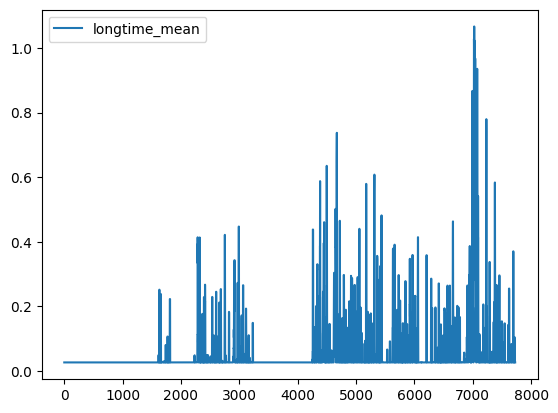

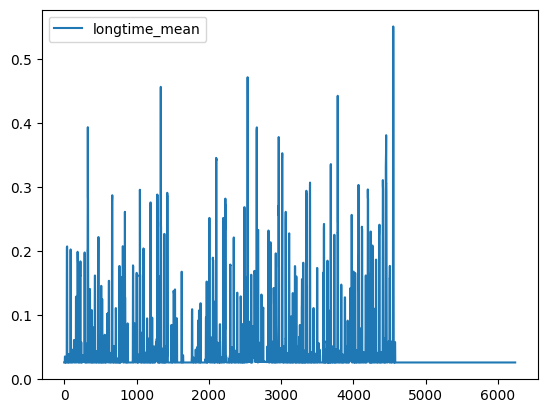

In [42]:
train_zuka.plot(y='longtime_mean')
train_form.plot(y='longtime_mean')

<AxesSubplot:>

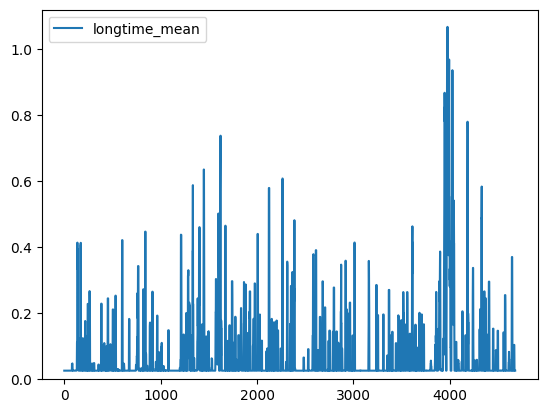

In [43]:
# print gaps in time in train
train_zuka_cut = pd.concat([train_zuka[2150:3300], train_zuka[4200:]])
train_zuka_cut = train_zuka_cut.reset_index(drop=True)
train_zuka_cut.plot(y='longtime_mean', kind='line', ylim=0)
# train_zuka_cut = train_zuk
# train_zuka_cut = train_zuka_cut.reset_index(drop=True)

# train_zuka_cut.plot(y='longtime_mean', k÷ind='line', ylim=0)


<AxesSubplot:>

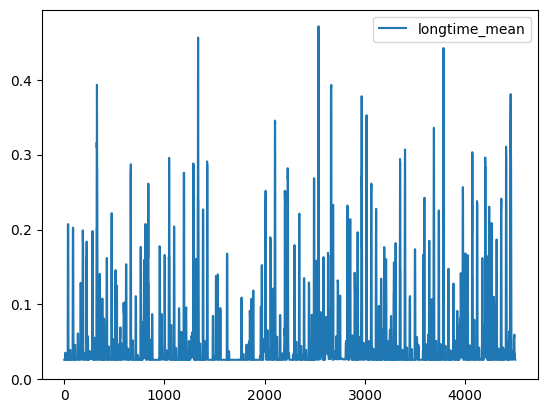

In [44]:

train_form_cut = train_form[0:4500]
train_form_cut.plot(y='longtime_mean', kind='line', ylim=0)

In [45]:

from pytz import utc
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_data = datetime(2023, 12, 10)
end_of_training_data = datetime(2023, 12, 31, 0, 0, 0)
dataHandler = DataHandler(
    "localhost",
    "smart_home_zukalovi",
    "root",
    "root",
    "shelly1pm_84cca8b07eae",
    "shelly1pm_84cca8b07eae_power",
    "esphome_web_c771e8_tmp3",
    "esphome_web_c771e8_ntc_temperature_b_constant_2",
start_of_data,
)

forecast = Forecast(dataHandler, start_of_data=start_of_data, model_path='lstm_model_zukalovi.keras')
# forecast.load_model(left_time_interval=start_of_data, right_time_interval=end_of_training_data)







In [46]:
training_data_merged = pd.concat([train_zuka_cut, train_form_cut])

In [47]:
# forecast.load_model(left_time_interval=datetime(2024, 1, 1, 0, 0, 0, 0), right_time_interval=datetime(2024, 2, 1, 0, 0, 0))

In [48]:

forecast.train_model(df_training_data=train_zuka_cut)
forecast.build_model()

# # forecast.train_model(df_training_data=train_zuka_cut)
# # forecast.build_model()

# # forecast.train_model(df_training_data=train_form_cut)
forecast.fit_model()

Start training
Epoch 1/100
1401/1401 - 3s - loss: 0.5582 - r2_keras: -3.0807e+05 - val_loss: 2.0147 - val_r2_keras: -2.4969e+06 - 3s/epoch - 2ms/step
Epoch 2/100
1401/1401 - 2s - loss: 0.4122 - r2_keras: -2.3347e+04 - val_loss: 0.4010 - val_r2_keras: -4.3871e+06 - 2s/epoch - 1ms/step
Epoch 3/100
1401/1401 - 2s - loss: 0.4058 - r2_keras: -2.5092e+04 - val_loss: 1.5995 - val_r2_keras: -2.1148e+06 - 2s/epoch - 1ms/step
Epoch 4/100
1401/1401 - 2s - loss: 0.3983 - r2_keras: -6.2922e+04 - val_loss: 0.3781 - val_r2_keras: -3.9588e+06 - 2s/epoch - 1ms/step
Epoch 5/100
1401/1401 - 2s - loss: 0.3815 - r2_keras: -3.6575e+04 - val_loss: 1.7401 - val_r2_keras: -2.1315e+06 - 2s/epoch - 1ms/step
Epoch 6/100
1401/1401 - 2s - loss: 0.3879 - r2_keras: -7.7312e+04 - val_loss: 0.3760 - val_r2_keras: -4.2617e+06 - 2s/epoch - 1ms/step
Epoch 7/100
1401/1401 - 2s - loss: 0.3913 - r2_keras: -2.9621e+04 - val_loss: 1.7156 - val_r2_keras: -2.2547e+06 - 2s/epoch - 1ms/step
Epoch 8/100
1401/1401 - 2s - loss: 0.390

In [85]:
one_week_prediction = []
number_of_30_minutes = 14*24*2
end_train = datetime(2024,3,1, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=25)

start_of_prediction = end_of_data_loader_for_forecast
end_of_prediction = start_of_prediction + timedelta(days=14)

In [86]:
# iterate over one week by 30 minutes, get the prediction first value and save to variable one_week_prediction


for i in range(0, number_of_30_minutes):
    if i % 100 == 0:
        print(i)
    next_steps = forecast.get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps.values)
    start_of_data_loader_for_forecast += timedelta(minutes=30)
    end_of_data_loader_for_forecast += timedelta(minutes=30)

0
100
200
300
400
500
600


In [87]:
data_truth = dataHandler.get_data_for_training_model(left_time_interval=start_of_prediction, right_time_interval=end_of_prediction)

In [88]:
# Flatten the list of lists
flattened_list = [item for sublist in one_week_prediction for item in sublist]
print(len(flattened_list))

# Reshape the flattened list to make it 2D
reshaped_data = [flattened_list[i:i+12] for i in range(0, len(flattened_list), 12)]

# flatten the values of the reshaped list


8064


In [89]:

for row in reshaped_data:
    for i in range(0, len(row)):
        row[i] = row[i][0]

In [90]:
import pandas as pd

In [91]:
df = pd.DataFrame(reshaped_data)
print(df.shape)
df['truth'] = data_truth[0]['longtime_mean'].values


(672, 12)


In [123]:
print(df.shape)
print()
df_shift = df.copy()
# shift to the top based on column = 0 no, 1 1, 2 2
for i in range(0, 12):
    df_shift[i] = df_shift[i].shift(-i-1)
    # remove list from value
    

print(df_shift)



(672, 13)

            0         1         2         3         4         5         6  \
0    0.026083  0.026080  0.026100  0.026093  0.036328  0.039529  0.042015   
1    0.026086  0.026084  0.026085  0.026092  0.026116  0.026105  0.026112   
2    0.026080  0.026100  0.026091  0.026096  0.043388  0.038131  0.041679   
3    0.026084  0.026085  0.026086  0.026096  0.026112  0.026109  0.026120   
4    0.026100  0.026091  0.026095  0.026097  0.044407  0.036743  0.041780   
..        ...       ...       ...       ...       ...       ...       ...   
667  0.026091  0.026091  0.026092  0.026100       NaN       NaN       NaN   
668  0.026081  0.026077  0.026083       NaN       NaN       NaN       NaN   
669  0.026091  0.026092       NaN       NaN       NaN       NaN       NaN   
670  0.026077       NaN       NaN       NaN       NaN       NaN       NaN   
671       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            7         8         9        10        11     truth 

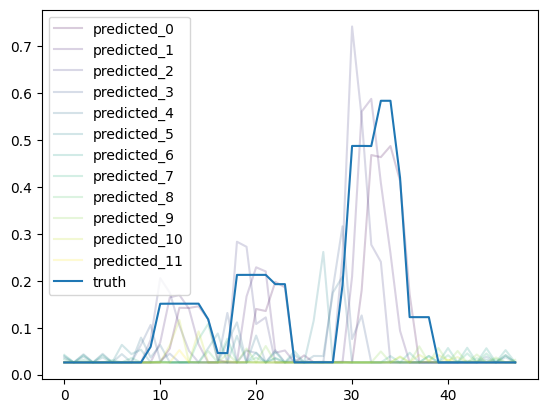

In [124]:
from turtle import color
import matplotlib.pyplot as plt
import numpy as np
number_of_steps = 12
#create a list of collors from 0 to 12 based on color
colors = plt.cm.viridis(np.linspace(0, 1, number_of_steps))
for i in range(0, number_of_steps):
    plt.plot(df_shift[i][:48], label=f'predicted_{i}', color=colors[i], alpha=0.2)
# i =0
# plt.plot(df_shift[i], label=f'{i}_step_ahead')
plt.plot(df_shift['truth'][:48], label='truth')
plt.legend()   
plt.show()

In [125]:
df_shift

,0,1,2,3,4,5,6,7,8,9,10,11,truth
0,0.026083,0.026080,0.026100,0.026093,0.036328,0.039529,0.042015,0.032836,0.026109,0.026112,0.026115,0.026111,0.026042
1,0.026086,0.026084,0.026085,0.026092,0.026116,0.026105,0.026112,0.026096,0.026106,0.026341,0.026111,0.026112,0.026042
2,0.026080,0.026100,0.026091,0.026096,0.043388,0.038131,0.041679,0.031186,0.026112,0.026117,0.026112,0.026119,0.026042
3,0.026084,0.026085,0.026086,0.026096,0.026112,0.026109,0.026120,0.026098,0.026113,0.026151,0.026099,0.026114,0.026042
4,0.026100,0.026091,0.026095,0.026097,0.044407,0.036743,0.041780,0.026114,0.026128,0.026157,0.026108,0.026115,0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.026091,0.026091,0.026092,0.026100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026056
668,0.026081,0.026077,0.026083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026046
669,0.026091,0.026092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026046
670,0.026077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026047


In [126]:
from scipy import stats
dropped_shift = df_shift.dropna()
statistics = {i: {'RMSE': 0, 'MSE': 0, 'MAE': 0, 'r2':0, 'slope':0, 'intercept':0, 'std_err':0, 'integral':0} for i in range(0, 12)}
statistics['truth'] = {'RMSE': 0, 'MSE': 0, 'MAE': 0, 'r2':0, 'slope':0, 'intercept':0, 'std_err':0, 'integral':0}
statistics['truth']['integral'] = np.trapz(dropped_shift['truth'])
for i in range(0, 12):
    #  count rmse, mse, mae with df_shift['true] and df_shift[i]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=dropped_shift[i],y=dropped_shift["truth"])

    statistics[i]['RMSE'] = np.sqrt(np.mean((dropped_shift["truth"] - dropped_shift[i])**2))
    statistics[i]['MSE'] = np.mean((dropped_shift["truth"] - dropped_shift[i])**2)
    statistics[i]['MAE'] = np.mean(np.abs(dropped_shift["truth"] - dropped_shift[i]))
    statistics[i]["r2"] = r_value*r_value
    statistics[i]["integral"] = np.trapz(dropped_shift[i])
    print(r_value**2)
    statistics[i]["slope"] = slope
    statistics[i]["intercept"] = intercept
    statistics[i]["std_err"] = std_err
    

0.6628635463279238
0.6547823285385794
0.4933719820409981
0.016194425268578515
0.0022999035815857993
0.007748585587800831
0.0003553963592677653
0.0036664470666819783
0.004289728333431734
0.0012168988106970615
2.3727406246002053e-05
0.0016657695046904564


In [127]:
# plot integral of all columns
import matplotlib.pyplot as plt
import numpy as np

for key, value in statistics.items():
    print(key, value['integral'])

0 32.52121093811965
1 32.65083139682112
2 33.16741782503716
3 21.898534214928645
4 23.486985927396518
5 21.88734278009464
6 22.02707366640329
7 20.015415279129716
8 18.24603789174332
9 21.087425206261805
10 18.861042735957824
11 17.89734675817149
truth 42.28194682391608


<AxesSubplot:>

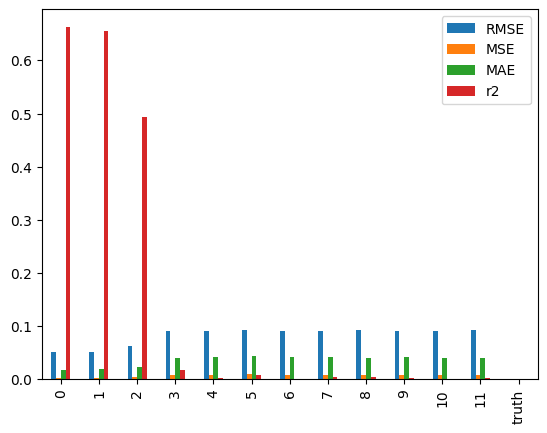

In [128]:
# plot stats
stats_df = pd.DataFrame(statistics)
stats_df = stats_df.T
stats_df.plot(kind='bar', y=['RMSE', 'MSE', 'MAE', 'r2'])

In [129]:
data_truth_longtime_mean = data_truth[0]['longtime_mean']

In [130]:
from operator import le
import pandas as pd
import numpy as np

forecast_begin_date = datetime(2024, 1, 4, 6, 0, 0)
queries = dataHandler.get_database_queries(
    left_time_interval=forecast_begin_date - timedelta(hours=12),
    right_time_interval=forecast_begin_date,
)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)
df_all.index = df_all.index.tz_localize(None)
df_all, _ = dataHandler.transform_data_for_ml(df_all, predicted_column="longtime_mean")
df_test = df_all.copy()
df_test = df_test[-12:]
df_all = df_all[:-12]
df_all_copy = df_all.copy()
forecast_future = pd.DataFrame()

current_forecast_begin_date = forecast_begin_date
current_forecast_end_date = forecast_begin_date + timedelta(minutes=30)
for i in range(0, 6):
    print("-----")

    df_predict = pd.DataFrame(
        {
            "datetime": pd.date_range(
                current_forecast_begin_date, current_forecast_end_date, freq="30min"
            )
        }
    )
    df_predict["longtime_mean"] = 0
    df_predict["weekday_sin"] = np.sin(
        2 * np.pi * df_predict["datetime"].dt.weekday / 7
    )
    df_predict["weekday_cos"] = np.cos(
        2 * np.pi * df_predict["datetime"].dt.weekday / 7
    )
    df_predict["hour_sin"] = np.sin(2 * np.pi * df_predict["datetime"].dt.hour / 24)
    df_predict["hour_cos"] = np.cos(2 * np.pi * df_predict["datetime"].dt.hour / 24)
    df_predict["minute_sin"] = np.sin(2 * np.pi * df_predict["datetime"].dt.minute / 60)
    df_predict["minute_cos"] = np.cos(2 * np.pi * df_predict["datetime"].dt.minute / 60)
    # delete column datetime
    df_predict = df_predict.drop(columns="datetime")
    len_df_predict = df_predict.shape[0]

    # concar df_all and df_predict

    df_all = pd.concat([df_all, df_predict], axis=0)
    df_all = df_all.reset_index(drop=True)

    df_predict_norm = df_all.copy()
    df_predict_norm[df_all.columns] = forecast.scaler.transform(df_all)
    # create predict df with values

    predict_gen = forecast.generator(
        dataframe=df_predict_norm,
        target_name=forecast.predicted_column,
        lookback=forecast.lookback,
        delay=forecast.delay,
        min_index=0,
        max_index=None,
        step=1,
        shuffle=False,
        batch_size=df_predict.shape[0],
    )

    (X, y_truth) = next(predict_gen)

    y_pred = forecast.model.predict(X)

    # np.expand_dims(y_truth,axis=1).shape
    y_pred_inv = np.concatenate(
        (y_pred, np.zeros((y_pred.shape[0], forecast.num_of_features))), axis=1
    )
    y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
    y_pred_inv = y_pred_inv[:, 0]
    # set df_all last len_df_predict values to y_pred_inv
    df_all.iloc[-len_df_predict:, df_all.columns.get_loc("longtime_mean")] = y_pred_inv
    # plt.plot(df_all.iloc[-len_df_predict:, df_all.columns.get_loc('longtime_mean')], color = 'green', label = 'Predicted data')
    df_all = df_all[len_df_predict:]
    forecast_future = pd.concat([forecast_future, df_all[-len_df_predict:]], axis=0)
    forecast_future = forecast_future.reset_index(drop=True)

    current_forecast_begin_date = current_forecast_begin_date + timedelta(hours=1)
    current_forecast_end_date = current_forecast_end_date + timedelta(hours=1)


-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 10ms/step


<AxesSubplot:>

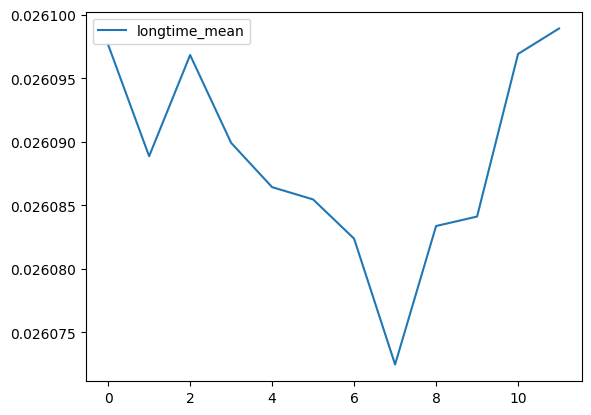

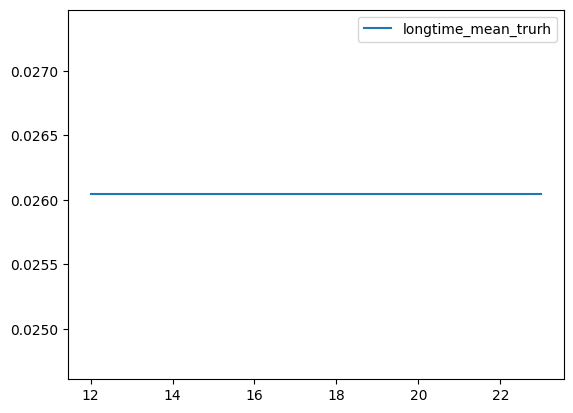

In [131]:
forecast_future.plot(y='longtime_mean', label='longtime_mean')
df_test.plot(y='longtime_mean', label='longtime_mean_trurh')

In [132]:
print(forecast_future['longtime_mean'])

0     0.026098
1     0.026089
2     0.026097
3     0.026090
4     0.026086
5     0.026085
6     0.026082
7     0.026072
8     0.026083
9     0.026084
10    0.026097
11    0.026099
Name: longtime_mean, dtype: float64


In [133]:
# plt.plot(forecast_future['consumed_heat_kWh'], label="Predicted")

begin = datetime(2024, 1, 1, 0, 0, 0) 
end = datetime(2024, 1, 1, 23, 59, 59)

queries = dataHandler.get_database_queries(left_time_interval=begin - timedelta(days=1), right_time_interval=begin)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)

In [134]:

df_all, _= dataHandler.transform_data_for_ml(df_all, predicted_column='longtime_mean')



In [135]:
from sklearn.metrics import mean_squared_error
from scipy import stats
import numpy as np

df_predict_norm = df_all.copy()
df_predict_norm[df_predict_norm.columns] = forecast.scaler.transform(df_all)
# create predict df with values 

predict_gen = forecast.generator(dataframe = df_predict_norm, 
        target_name = forecast.predicted_column, 
        lookback = forecast.lookback,
        delay = forecast.delay,
        min_index = 0,
        max_index = None,
        step = 1,
        shuffle = False,
        batch_size = df_predict_norm.shape[0])

(X, y_truth) = next(predict_gen)

y_pred = forecast.model.predict(X)

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate((y_pred,np.zeros((y_pred.shape[0],forecast.num_of_features))),axis=1)
y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:,0]

y_truth_inv = np.concatenate((np.expand_dims(y_truth,axis=1),np.zeros((y_truth.shape[0],forecast.num_of_features))),axis=1)
y_truth_inv = forecast.scaler.inverse_transform(y_truth_inv)
y_truth_inv = y_truth_inv[:,0]

statistics = {}
slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv,y=y_truth_inv)
mse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=True)
rmse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=False)

statistics['slope'] = slope
statistics['intercept'] = intercept
statistics['r_value'] = r_value
statistics['p_value'] = p_value
statistics['std_err'] = std_err
statistics['mse'] = mse
statistics['rmse'] = rmse




2/2 [==============================] - 0s 1ms/step


In [136]:
print(statistics)

{'slope': 1.2308025229471677, 'intercept': 0.021719832772705214, 'r_value': 0.8627418794209211, 'p_value': 8.237161026070274e-13, 'std_err': 0.11702026107626151, 'mse': 0.008380209629696898, 'rmse': 0.09154348491125351}


In [137]:
import matplotlib.pyplot as plt
df = pd.concat(df_all_list, axis=1)
df = df[['water_flow_L_per_hour_mean', 'water_temperature_mean', 'boiler_wattage_mean']]
df['water_flow_L_per_hour_mean'] = df['water_flow_L_per_hour_mean']

df = df.resample('1min').mean()
df[f"consumed_heat_kJ"] = (
            df[f"water_flow_L_per_hour_mean"]
            * (df[f"water_temperature_mean"] - 10)
            * 4.186
            * 0.5
            
            
        )
df['boiler_wattage_kWh'] = df['boiler_wattage_mean'] / (1000*60)
df = df.groupby(pd.Grouper(freq='7D'))
df = df.agg({'consumed_heat_kJ': 'sum', 'water_flow_L_per_hour_mean': 'mean', 'water_temperature_mean': 'mean', 'boiler_wattage_kWh': 'sum'})
        
# df consumed_heat_kJ to kWh
df[f"consumed_heat_kWh"] = df[f"consumed_heat_kJ"] / (3600)
df[f"consumed_heat_kWh"] += 0.4*7
print(df)

df['heat_loss'] = df['consumed_heat_kWh'] - df['boiler_wattage_kWh']

plt.plot( df['boiler_wattage_kWh'], label="boiler_heat_kWh")
plt.plot( df['consumed_heat_kWh'], label="consumed_heat_kWh")
plt.legend()



NameError: name 'df_all_list' is not defined